In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graph_vis import draw_dot

In [2]:
def f(x):
    return 3*x**2 - 4*x + 2

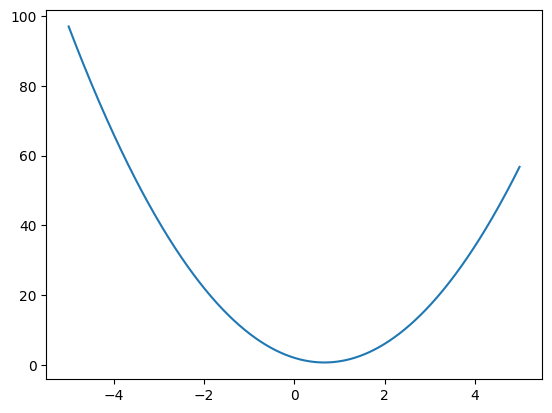

In [4]:
xs = np.arange(-5, 5, 0.01)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [10]:
# Derivative
x = -10
h = 0.00000001
(f(x + h) - f(x))/h

-64.00000529538374

In [20]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d = a*b + c

b += h
d2 = a*b + c

print("d1: ", d)
print("d2: ", d2)
print("slope: ", (d2 - d)/h)

d1:  4.0
d2:  4.0002
slope:  2.0000000000042206
